In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.interpolate import interp2d, LinearNDInterpolator
import randomlatticethermalized as rlt
import movies_from_plots as mfp
import selfpropelledparticlevoronoi as sppv
import pathlib
from scipy import ndimage as nd 
import h5py as h5
import importlib

In [29]:
import topologicaltransitions as tpt

In [30]:
importlib.reload(mfp)
importlib.reload(sppv)
importlib.reload(rlt)
importlib.reload(tpt)

<module 'topologicaltransitions' from '/home/rafael/Documents/tissuewoundmodelling-main/SpringNetworkSimul/topologicaltransitions.py'>

# Making a network

In [38]:
N = 5**2
L_max = 5
L_min = -5

x_coord = (L_max-L_min)*(np.random.rand(N)) + L_min
y_coord = (L_max-L_min)*(np.random.rand(N)) + L_min

coords = np.array((x_coord,y_coord)).T

In [3]:
N_m = 3
L_max = 5
L_min = -5  
dL = (L_max-L_min)/N_m
#A_0 = np.array([[1,0],[-1/2,np.sqrt(3)/2]])
A_0 = np.eye(2)
A = 1/(2*np.linalg.det(A_0))*(A_0.T+A_0)
A_inv = np.linalg.inv(A)

LxyM = A_inv.dot(np.array([L_max,L_max]))
Lxym = A_inv.dot(np.array([L_min,L_min]))

u = np.linspace(Lxym[0],LxyM[0],N_m)
v = np.linspace(Lxym[1],LxyM[1],N_m)

coord_list = []

for j in range(N_m):
    for i in range(N_m):
        coord_list.append(A.dot(np.array([u[j],v[i]])))
        
coords = np.array(coord_list)
N = N_m**2

# Reciprocal network

In [ ]:
xy_hist = np.histogram2d(coords[:,0],coords[:,1],bins=200)
fft_hist = np.fft.fft2(nd.gaussian_filter(xy_hist[0],0))

dx = dL*N_m/200

freq = np.linspace(0,1,100)/(2*dx)
fft_x = np.mean(np.abs(np.fft.fftshift(fft_hist)),axis=1)
fft_y = np.mean(np.abs(np.fft.fftshift(fft_hist)),axis=0)

In [ ]:
#plt.pcolormesh(xy_hist[1],xy_hist[2],nd.gaussian_filter(xy_hist[0],1))
plt.pcolormesh(xy_hist[1],xy_hist[2],np.abs(np.fft.fftshift(fft_hist)))
#plt.plot(coords[:,0],coords[:,1],'.')

In [ ]:
plt.plot(freq[:],(fft_x-0*nd.gaussian_filter(fft_x,1))[100:])
#plt.plot((fft_y-nd.gaussian_filter(fft_y,0.4))[100:])

# 

In [4]:
vor = Voronoi(coords)
vorPointRegion = vor.point_region
vorRegions = vor.regions
vorRidges = sppv.remove_minus(vor.ridge_vertices)
vorVertices = vor.vertices

In [23]:
#sppv.remove_minus(vor.ridge_vertices)

In [5]:
sppv.find_center_neighbour_center(vorRegions,vorPointRegion,2)

[1, 4, 5]

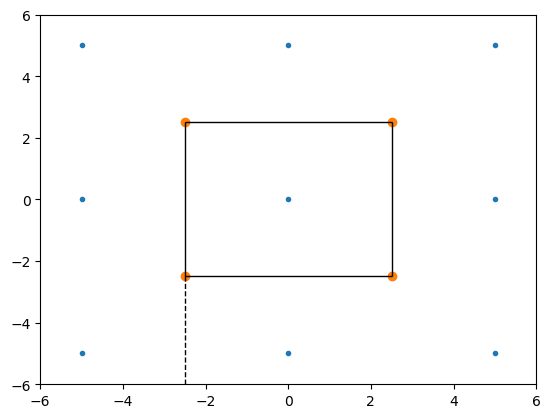

In [6]:
#plt.plot(coords[1,0],coords[1,1],'ro')
#plt.plot(vorVertices[:,0],vorVertices[:,1],'o')
#plt.plot(np.mean(vorVertices[vorRegions[8],0],0),np.mean(vorVertices[vorRegions[8],1],0),'o')
voronoi_plot_2d(vor)
plt.show()


In [32]:
DeltaL = L_max - L_min
r0 = DeltaL/(3*np.sqrt(N))

#Model parameters
K_run = 0.3
A0_run = np.pi*r0**2
G_run = 1
L_run = -1

In [42]:
vorVertices[0]

array([-2.5, -2.5])

In [46]:
def F_vertex(K,A0,G,L,vu,vb,va,A,P):
    z = np.array([0,0,1])
    
    nA = np.cross(z,va-vb)[:-1]
    
    rua = vu - va
    rbu = vb - vu
    nua = rua/sppv.norm(rua)
    nbu = rbu/sppv.norm(rbu)
    nP = nua - nbu
    
    F = -K/2*(A-A0)*nA - (G*P+L)*nP
    return F

def F_square(K,A0,G,L,A,P):
    v_array = np.array([[-2.5, -2.5],
       [ 2.5, -2.5],[2.5, 2.5],[-2.5,  2.5]])
    F_v = []
    for i in range(4):
        vu = v_array[i]
        va = v_array[(i-1)%4]
        vb = v_array[(i+1)%4]
        F_v.append(F_vertex(K,A0,G,L,vu,vb,va,A,P))
    return np.array(F_v)
    

In [82]:
dx_list = 10**(np.linspace(-15,0.5,100))


In [83]:
F_vertex1 = F_square(K_run,A0_run, G_run, L_run, 25, 20)
F_vertex2 = sppv.force_vtx_elastic(vorRegions, vorPointRegion, vorRidges, K_run,A0_run,G_run,L_run,vorVertices,coords,1e-6)

In [87]:
FV1 = []
FV2 = []
F_vertex1 = F_square(K_run,A0_run, G_run, L_run, 25, 20)
for dx in dx_list:
        vor = Voronoi(coords)
        vorPointRegion = vor.point_region
        vorRegions = vor.regions
        vorRidges = sppv.remove_minus(vor.ridge_vertices)
        vorVertices = np.array(vor.vertices)
        
        
        F_vertex2 = sppv.force_vtx_elastic(vorRegions, vorPointRegion, vorRidges, K_run,A0_run,G_run,L_run,vorVertices,coords,dx)
        
        
        err1 = np.zeros((len(F_vertex1),2))

        for i in range(len(F_vertex1)):
                err1[i] = np.abs(F_vertex2[i]-F_vertex1[i])/np.abs(F_vertex1[i])
                #err1[i,1] = np.abs(F_vertex2[i,1]-F_vertex1[i,1])/np.abs(F_vertex1[i,1])
                #np.abs(np.inner(F_vertex2[i],F_vertex1[i])/np.inner(F_vertex1[i],F_vertex1[i]))
                #err1_abs = np.zeros((len(err1),))
        

        FV1.append(np.median(err1[:2],0))

     
        

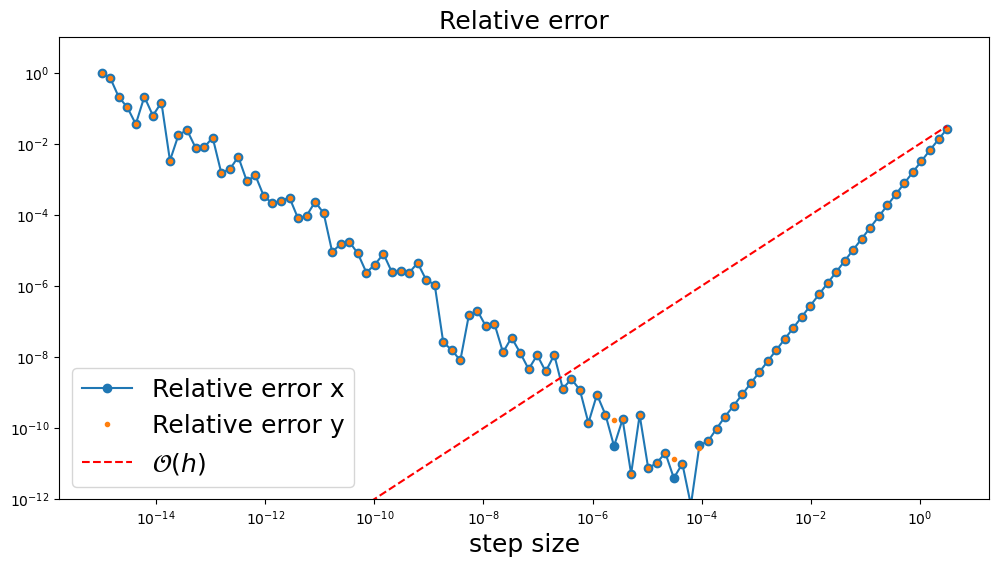

In [101]:
plt.figure(figsize=(12,6))
plt.plot(dx_list,np.array(FV1)[:,0],'-o')
plt.plot(dx_list,np.array(FV1)[:,1],'.')
#plt.plot(dx_list,FV2)
plt.plot(dx_list,1e-2*dx_list,'r--')
#plt.plot(dx_list,dx_list**0,'k--')
#plt.plot(dx_list,2+dx_list**2,'g--')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-12,10)
plt.title("Relative error", fontsize = 18)
plt.xlabel("step size", fontsize= 18)
plt.legend(["Relative error x","Relative error y","$\mathcal{O}(h)$"], fontsize = 18)

dx

In [77]:
FV12 = []
FV22 = []


K_list = 10**(np.linspace(-5,1,20))
for K in K_list:
        vor = Voronoi(coords)
        vorPointRegion = vor.point_region
        vorRegions = vor.regions
        vorRidges = sppv.remove_minus(vor.ridge_vertices)
        vorVertices = np.array(vor.vertices)
        
        F_vertex1 = F_square(K,A0_run, G_run, L_run, 25, 20)
        F_vertex2 = sppv.force_vtx_elastic(vorRegions, vorPointRegion, vorRidges, K,A0_run,G_run,L_run,np.array(vorVertices),np.array(coords),1e-4)
        
        
        err1 = np.zeros((len(F_vertex1),2))
        for i in range(len(F_vertex1)):
                err1[i,0] = np.abs(F_vertex1[i,0]-F_vertex2[i,0])#/np.abs(F_vertex1[i,0])
                err1[i,1] = np.abs(F_vertex2[i,0]/F_vertex1[i,0])
                #np.abs(np.inner(F_vertex2[i],F_vertex1[i])/np.inner(F_vertex1[i],F_vertex1[i]))
                #err1_abs = np.zeros((len(err1),))
        
        FV12.append(err1[0])
     
        

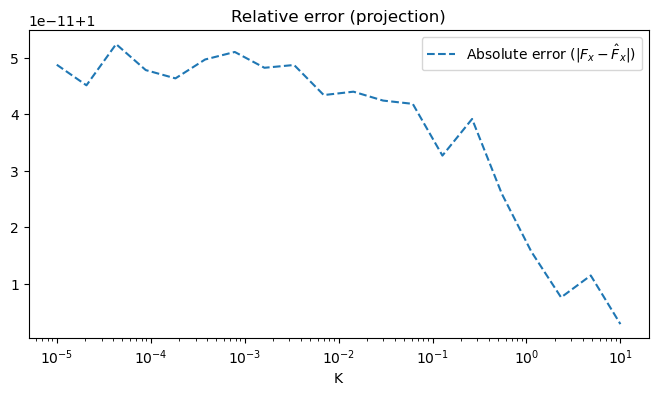

In [78]:
plt.figure(figsize=(8,4))
#plt.plot(K_list,np.array(FV12)[:,0])
plt.plot(K_list,np.array(FV12)[:,1],'--')
#plt.plot(K_list,FV22)
#plt.plot(dx_list,1+dx_list,'r--')
#plt.plot(dx_list,dx_list**0,'k--')
#plt.plot(dx_list,2+dx_list**2,'g--')
plt.xscale('log')
#plt.yscale('log')
#plt.ylim(0,100)
plt.title("Relative error (projection)")
plt.xlabel("K")
plt.legend(["Absolute error ($|F_x-\hat{F}_x|$)","$\hat{F}_x/F_x$"])